Tim Rose

https://towardsdatascience.com/conditional-variational-autoencoders-with-learnable-conditional-embeddings-e22ee5359a2a

# Introduction

I recently came across the paper: “Population-level integration of single-cell datasets enables multi-scale analysis across samples”, where the authors developed a CVAE model with learnable conditional embeddings. I found this idea pretty interesting and think it is worth sharing here. In this article, I will not discuss the biological applications of the proposed model, but instead, break down their idea for a simple example case on handwritten digits from the MNIST dataset.

So, let’s get started. The C in CVAE stands for “conditional”. This means that the encoder and decoder in addition to the input data (e.g. image for the encoder and latent vector for the decoder) are provided with an encoding for a condition. Therefore, the encoder does not need to represent the condition in the latent space since the decoder will also get this information as an extra input. Hence, the encoder can regress out the condition and learn e.g. the handwriting style as a latent representation.

In practice, conditions in CVAE models are commonly one-hot encoded. E.g. for the MNIST dataset with 10 different digits, we would use a size 10 vector. PyTorch provides a function to create one-hot encodings from integer labels:

In [1]:
import torch

digits = torch.tensor([0,1,2,3])
torch.nn.functional.one_hot(digits, 10)

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

One-hot encodings work well, however, a trained model is limited to the conditions provided during training, due defined dimensions of the condition vector. If a CVAE model is trained on the MNIST dataset for the digits 0-7 (using a size 8 one hot encoding), inference cannot be performed for digits 8 and 9.

In the publication that inspired this article, the authors are interested in the latent space generated from the encoder and want to integrate new conditions into the latent space without retraining the model. To achieve this, they use embedding vectors for each condition, whose values are learned during training. If a new condition is added to the model, all model weights can be frozen except the values of a new condition embedding vector. What I find interesting about this approach, is the assumption that the model is essentially learning another latent space of condition (digit) representation hat can be used to interpolate and create embeddings for new digits the model has not seen before.

Before implementing such a CVAE model, let’s make a simple CVAE with one-hot encoded conditions which we can later compare to the new model.

# CVAE with one-hot encoded conditions

First, let's load all required python packages:

In [2]:
%%capture
!pip install lightning

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.utils
import torch.distributions
import torchvision
import lightning.pytorch as pl

import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Next, we load the MNIST data:

In [4]:
data = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('.', transform=torchvision.transforms.ToTensor(), download=True),
    batch_size=128,
    shuffle=True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 244874141.52it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 40018399.02it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 63971467.65it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 23694687.52it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



The model consists of an encoder and decoder. We first define the encoder, which takes as input the images and one-hot encoding and outputs a latent vector z. Additionally, it computes the KL-divergence as an additional loss term for the CVAE:

In [5]:
class CondVariationalEncoder(nn.Module):

    # The encoder gets the label as a one-hot encoding
    def __init__(self, latent_dims, n_classes):
        super(CondVariationalEncoder, self).__init__()
        # The dimensions of the one-hot encoding are concatenated to the input
        self.linear1 = nn.Linear(784 + n_classes, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        # Get sampling working on GPU
        self.N.loc = self.N.loc.cuda()
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    # The labels are provided as variable 'y'
    def forward(self, x, y):
        x = torch.flatten(x, start_dim=1)
        x = x.view(-1, 1*28*28)
        # Here the label one-hot encoding is concatenated to the image
        x = functional.relu(self.linear1(torch.cat((x, y), dim=1)))
        # Mean
        mu = self.linear2(x)
        # Variance
        sigma = torch.exp(self.linear3(x))

        # Sample latent vector for images
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

The decoder is much simpler since it just uses the images and one-hot encodings to infer images:

In [6]:
class CondVariationalDecoder(nn.Module):

    # The decoder gets the label as a one-hot encoding
    def __init__(self, latent_dims, n_classes):
        super(CondVariationalDecoder, self).__init__()
        # The dimensions of the one-hot encoding are concatenated to the input
        self.linear1 = nn.Linear(latent_dims + n_classes, 512)
        self.linear2 = nn.Linear(512, 784)

    # Labels are provided as variable 'y'
    def forward(self, z, y):
        # Here the label one-hot encoding is concatenated to the image
        z = functional.relu(self.linear1(torch.cat((z, y), dim=1)))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In the next step, we combine them into one module:

In [7]:
class CondVariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, n_classes):
        super(CondVariationalAutoencoder, self).__init__()
        self.encoder = CondVariationalEncoder(latent_dims, n_classes)
        self.decoder = CondVariationalDecoder(latent_dims, n_classes)

    def forward(self, x, y):
        z = self.encoder(x, y)
        return self.decoder(z, y)

This module performs both the encoding and decoding in the forward pass.

Since we will train the model using the lightning framework, we need one more wrapper for the CVAE module:

In [8]:
class CVAEModel(pl.LightningModule):
    def __init__(self, latent_dims, n_classes):
        super().__init__()
        self.cvae = CondVariationalAutoencoder(latent_dims, n_classes)
        self.n_classes = n_classes

    # Lightning requires a training step function in which the forward
    # step is executed and loss calculated
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_oh = torch.nn.functional.one_hot(y, num_classes=self.n_classes)

        x_hat = self.cvae(x, y_oh)
        loss = ((x - x_hat)**2).sum() + self.cvae.encoder.kl

        self.log('Training loss', loss, on_step=False, on_epoch=True, logger=False, prog_bar=True)

        return loss

    # Defining the optimizer
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=.02)

In the lightning module, we also perform the one-hot encoding of the digit labels during each forward pass.

Now, let’s train the model:

In [9]:
latent_dims = 2
model = CVAEModel(latent_dims=latent_dims, n_classes=10)

trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=10)
trainer.fit(model, data)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name | Type                       | Params
----------------------------------------------------
0 | cvae | CondVariationalAutoencoder | 817 K 
----------------------------------------------------
817 K     Trainable params
0         Non-trainable params
817 K     Total params
3.272     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


We will not perform a quantitative evaluation of the model performance for this article, but we can visually check how well the model is able to generate digits from the latent space. To do so, we create a grid in the latent space and letting the decoder generate images of the digits we are interested in. Since we only used a 2-dimensional latent space, we can use a 2D grid. For this, we define a plotting function:

In [10]:
def plot_reconstructed(autoencoder, r0=(-3, 3), r1=(-3, 3),
                       n=8, number=2, device='cuda'):
    # Define plot array:
    fig, axs = plt.subplots(n, n)

    # Loop over a grid in the latent space
    for i, a in enumerate(np.linspace(*r1, n)):
        for j, b in enumerate(np.linspace(*r0, n)):

            z = torch.Tensor([[a, b]]).to(device)
            # One-hot encoding of the integer
            y = functional.one_hot(torch.tensor([number]),
                                   num_classes=10).to(device)
            # Forwarding the data through the decoder
            x_hat = autoencoder.decoder(z, y)

            x_hat = x_hat.reshape(28, 28).detach().cpu().numpy()
            axs[i, j].imshow(x_hat)
            axs[i, j].axis('off')
    plt.show()

With this we can have a look at the generated images:

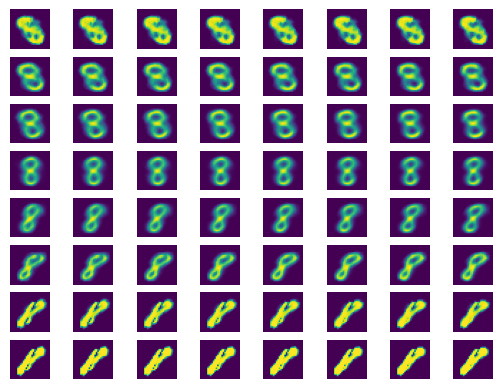

In [11]:
model = model.to(device)
plot_reconstructed(model.cvae, number=8, device=device)

Especially in the center of the latent space, the digits are very clear (Try to use other numbers as conditions and plot them yourself). Overall, the decoder is able to generate readable images of handwritten digits for all the provided numbers during training.

We are also interested in the latent space representation of all the digits in the training data. As mentioned before, we expect the model to remove digit-related differences in the latent space and, therefore, e.g. no clusters of images from the same digit. Below, we can visualize the 2D latent space and color it by the digit label. Further, we expect the latent space to be normally distributed around zero (due to our KL loss term).

<ipython-input-12-7b35cfb1f718>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.nn.functional.one_hot(torch.tensor(y),


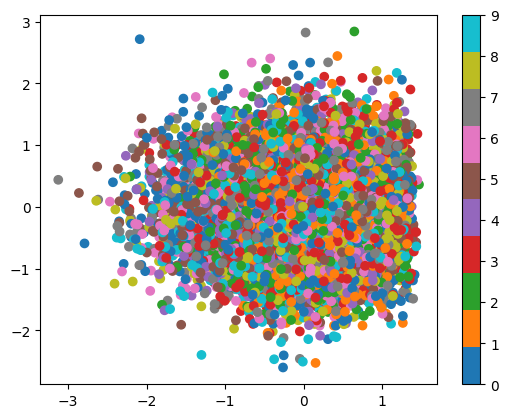

In [12]:
def plot_latent_cvae(autoencoder, data, num_batches=100, device='cpu'):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device),
                                torch.nn.functional.one_hot(torch.tensor(y),
                                                            num_classes=10).to(device))
        z = z.detach().cpu().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
model = model.to(device)
plot_latent_cvae(model.cvae, data, device=device)

# Learnable conditional embeddings

After building a first model, we switch to learnable embeddings. Instead of using one-hot encoding, we will now use learnable embeddings. These are also unique vectors for each condition, but with values that will be updated in the training process. The model optimizer will update the embedding vectors together with all other model parameters to improve the loss during training.

So we do not only have a latent space for images but also an embedding space for the conditions (digits). One of the central aspects of the paper is that the model is encoding information about (in our example case) the condition in the embedding vector. This means that we can add new digits to the model that were not included during training and the model might be able to infer the correct digit just with a new adjusted condition embedding. For this, all model weights are frozen and only the embeddings for the new digits which should be added to the model are optimized. In the publication, the authors intend to add a new condition to the latent space, but in this article, we will check how well the model can generate images of unseen digits.

First, we train a model on all digits to check the general ability of the CVAE model to train with learnable embeddings. For this, we define a new lightning module, but in this case include an embedding variable, which stores the embeddings and provides them in the forward pass:

In [14]:
class eCVAEModel(pl.LightningModule):
    # Here we need to define the number of classes and embedding dimensions
    def __init__(self, latent_dims, n_classes, embedding_dims):
        super().__init__()
        # We can use the CVAE model from the previous notebook,
        # but instead of using the number of classes for a one-hot encoding,
        # we use the embedding dimensions
        self.cvae = CondVariationalAutoencoder(latent_dims, embedding_dims)
        self.n_classes = n_classes
        self.embedding_dims = embedding_dims
        self.embed_cond = nn.Embedding(num_embeddings=n_classes, embedding_dim=embedding_dims, max_norm=True)

    def training_step(self, batch, batch_idx):
        x, y = batch

        # Instead of a one-hot encoding,
        # the embeddings are used as conditional variables
        x_hat = self.cvae(x, self.embed_cond(y))
        loss = ((x - x_hat)**2).sum() + self.cvae.encoder.kl

        self.log('Training loss', loss, on_step=False, on_epoch=True, logger=False, prog_bar=True)

        return loss

    # Defining the optimizer
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=.02)

Next, we can train the model:

In [15]:
emodel = eCVAEModel(latent_dims = latent_dims, n_classes=10, embedding_dims=5)

trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=10)
trainer.fit(emodel, data)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type                       | Params
----------------------------------------------------------
0 | cvae       | CondVariationalAutoencoder | 812 K 
1 | embed_cond | Embedding                  | 50    
----------------------------------------------------------
812 K     Trainable params
0         Non-trainable params
812 K     Total params
3.25

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


After training, we need a slightly updated plotting function to show generated images from the latent space that utilizes the condition embeddings:

In [16]:
def plot_reconstructed_ecvae(model, r0=(-3, 3), r1=(-3, 3),
                             n=8, number=2, device='cuda'):
    # Define plot array:
    fig, axs = plt.subplots(n, n)

    # Loop over a grid in the latent space
    for i, a in enumerate(np.linspace(*r1, n)):
        for j, b in enumerate(np.linspace(*r0, n)):

            z = torch.Tensor([[a, b]]).to(device)
            # One-hot encoding of the integer
            y = model.embed_cond(torch.tensor([number]).to(device))
            # Forwarding the data through the decoder
            x_hat = model.cvae.decoder(z, y)

            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            axs[i, j].imshow(x_hat)
            axs[i, j].axis('off')
    plt.show()

And we can finally generate new images. We again plot number 8 digits and can see that the model is equally well able to generate the digit.

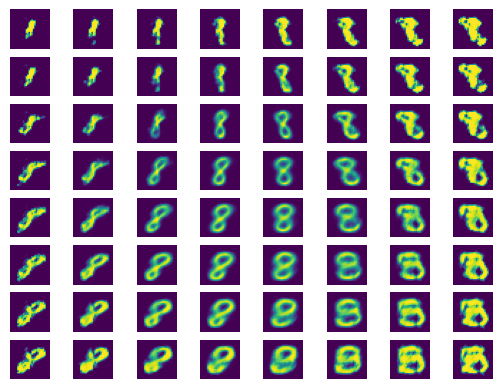

In [17]:
emodel = emodel.to(device)
plot_reconstructed_ecvae(emodel, number=8, device=device)

To visualize the latent space, we also need a slightly updated plotting function:

<ipython-input-18-4766c9850f58>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_embed = model.embed_cond(torch.tensor(y, device=device))


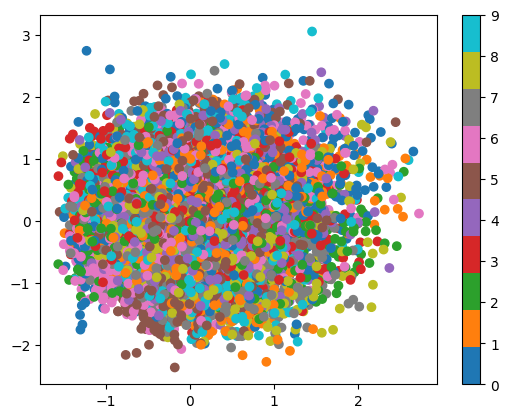

In [18]:
def plot_latent_ecvae(model, data, num_batches=100, device='cpu'):
    for i, (x, y) in enumerate(data):
        y_embed = model.embed_cond(torch.tensor(y, device=device))
        z = model.cvae.encoder(x.to(device), y_embed)
        z = z.detach().cpu().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

model = model.to(device)
plot_latent_ecvae(emodel, data, device=device)

While we can see a slightly changes distribution, we cannot see strong digit-related clusters. This shows that the model using learnable embeddings is similarly able to condition on the digits as the one hot encoded model (While the model is actually using fewer parameters since we only use an embedding of size 5 instead of 10 for the one hot encoding).

# Adding new conditions to the model

Finally, we are going to train the model only on the digits 0–7. After training, we then optimize the condition embeddings for the digits 8 and 9 while freezing all other model weights. This allows us to add these conditions to the latent space (and generate new images) without retraining the whole model. To do so, we create two new dataloaders, one for providing images of the digits 0–7 (datatrain) and another for providing the images for the digits 8 and 9 (data89):

In [19]:
# Creating dataloaders excluding 8 & 9 digits
# Code adapted from:
# https://stackoverflow.com/questions/75034387/remove-digit-from-mnist-pytorch
dstrain = torchvision.datasets.MNIST('/scratch/trose/mnist', transform=torchvision.transforms.ToTensor(), download=True)

idxn9 = dstrain.targets != 9
idxn8 = dstrain.targets != 8
idx = idxn9 & idxn8

dstrain.targets = dstrain.targets[idx]
dstrain.data = dstrain.data[idx]

# Data containing only 8 & 9 digits
ds89 = torchvision.datasets.MNIST('/scratch/trose/mnist', transform=torchvision.transforms.ToTensor(), download=True)

idx9 = ds89.targets == 9
idx8 = ds89.targets == 8
idx89 = idx9 | idx8
ds89.targets = ds89.targets[idx89]
ds89.data = ds89.data[idx89]

datatrain = torch.utils.data.DataLoader(dstrain, batch_size=128, shuffle=True)
data89 = torch.utils.data.DataLoader(ds89, batch_size=128, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 194502611.62it/s]

Extracting /scratch/trose/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /scratch/trose/mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 25845038.15it/s]


Extracting /scratch/trose/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /scratch/trose/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 85676483.15it/s]

Extracting /scratch/trose/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /scratch/trose/mnist/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 7914635.97it/s]


Extracting /scratch/trose/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /scratch/trose/mnist/MNIST/raw



We then first train the model on images of 0–7 digits:

In [20]:
emodel89 = eCVAEModel(latent_dims=latent_dims, n_classes=10, embedding_dims=5)

trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=10)
trainer.fit(emodel89, datatrain)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type                       | Params
----------------------------------------------------------
0 | cvae       | CondVariationalAutoencoder | 812 K 
1 | embed_cond | Embedding                  | 50    
----------------------------------------------------------
812 K     Trainable params
0         Non-trainable params
812 K     Total params
3.25

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


And then freeze all model parameters, except the condition embeddings. After that, we then optimize the embeddings only for images of the digits 8 and 9:

In [21]:
# Freeze model parameters
for name, param in emodel89.named_parameters():
    if name == 'embed_cond.weight':
        param.required_grad=True
    else:
        param.required_grad=False

# Training just on 8 & 9 digits on frozen weights
# The model is using the previously created embedding vectors in the model
# that were not updated for 8 & 9 in the previous training.
trainer89 = pl.Trainer(devices=1, accelerator='gpu', max_epochs=10)
trainer89.fit(emodel89, data89)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type                       | Params
----------------------------------------------------------
0 | cvae       | CondVariationalAutoencoder | 812 K 
1 | embed_cond | Embedding                  | 50    
----------------------------------------------------------
812 K     Trainable params
0         Non-trainable params
812 K     Total params
3.25

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Let’s visualize generated numbers and the latent space. Below we can see that the model is able to generate the images of the digit 8 similarly to our previous models, even though the model was not trained on these images and only the condition embedding vector has been updated.

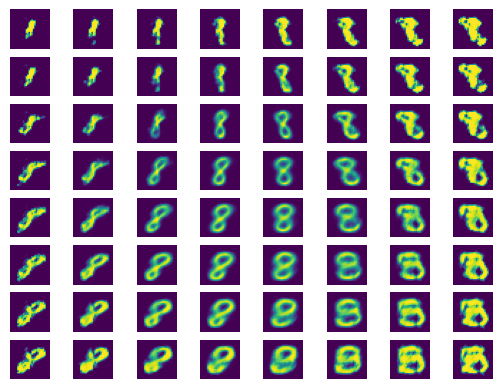

In [22]:
emodel89 = emodel.to(device)
plot_reconstructed_ecvae(emodel89, number=8, device=device)

If we visualize the latent space, we neither see clusters of 8 and 9 digits nor any strong outliers in the distribution.

<ipython-input-18-4766c9850f58>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_embed = model.embed_cond(torch.tensor(y, device=device))


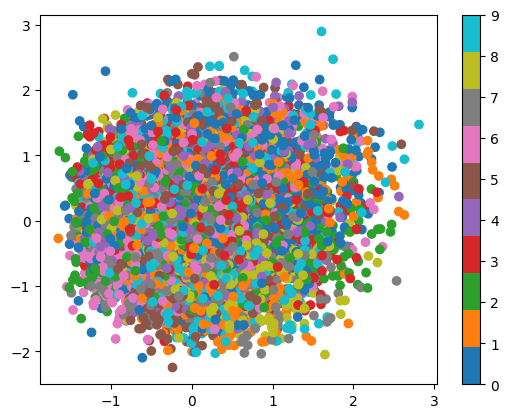

In [23]:
emodel89 = emodel89.to(device)
plot_latent_ecvae(emodel89, data, device=device)

While we did not do any kind of systematic evaluation of the model performance in this article, we can see that learned embedding can be very useful for adding new conditions to CVAE models, without retraining the whole model.

One-hot encodings are commonly used in machine learning, but I hope to have shown you an interesting alternative for it in CVAE models. If you are also interested in the applications of such an approach (e.g. in biology), I recommend the publication “[Population-level integration of single-cell datasets enables multi-scale analysis across samples](https://www.nature.com/articles/s41592-023-02035-2)”, which was the basis for this article. It also contains a few other interesting ideas for customizing CVAE models for specific applications.